In [1]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report

from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
from fetchData import fetchdata 

In [3]:
def train_test(X_train, X_test, y_train, y_test, clf):
    clf.fit(X_train, y_train)
    result = clf.predict(X_test)
    print("Accuracy:\t\t",accuracy_score(y_test,result))
    print('Precision Score:\t', str(precision_score(y_test,result)))
    print('Recall Score:\t\t' + str(recall_score(y_test,result)))
    print("F1 Score:\t\t",f1_score(y_test, result, average='macro', zero_division=True))
    print(classification_report(y_test, result))
    

def valid(X_valid, y_valid, clf):
    clf.fit
    result = clf.predict(X_valid)
    print("Accuracy:",accuracy_score(result,y_valid))
    print(classification_report(y_valid, result))

def cv_events(data):
    NUM_EVENT = data.Event.unique().shape[0]
    EVENTS = data.Event.unique()

    cv_pd_list = []
    for i, d in enumerate(EVENTS):
        df1, df2 = [x for _, x in data.groupby(data['Event'] != d)]
        df1.reset_index(inplace=True, drop=True)
        df2.reset_index(inplace=True, drop=True)
        cv_pd_list.append([df1, df2])
    return cv_pd_list

def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [5]:
pheme_AVGw2v = pd.read_csv('./data/_PHEME_text_AVGw2v.csv').drop(['token'],axis=1)
pheme_sparse = pd.read_csv('./data/_PHEME_sparse.csv')
pheme_y = pd.read_csv('./data/_PHEME_target.csv').target
pheme_event = pd.read_csv('./data/_PHEME_text.csv')['Event']
pheme_bert = fetchdata('pheme','bert')
# pd.read_csv('./data/_PHEME_text_AVGw2v.csv')

ext_AVGw2v = pd.read_csv('./data/_PHEMEext_text_AVGw2v.csv').drop(['token'],axis=1)
ext_sparse = pd.read_csv('./data/_PHEMEext_sparse.csv')
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target
ext_event = pd.read_csv('./data/_PHEMEext_text.csv').Event
ext_bert = fetchdata('ext','bert')

rhi = pd.read_csv('./data/_RHI_text_AVGw2v.csv').drop(['token'],axis=1)
rhi_y = pd.read_csv('./data/_RHI_target.csv')
rhi_bert = fetchdata('rhi','bert')

# temp = pd.read_csv('./data/previous/data_notembeded.csv')

# pd.concat([pheme_sparse, pheme_event])

In [24]:
def nothing():
    # pheme_sparse.verified = pheme_sparse.verified.replace({True: 1, False: 0}) 
    # ext_sparse.verified = ext_sparse.verified.replace({True: 1, False: 0}) 
    # pheme_sparse.has_question = pheme_sparse.has_question.replace({True: 1, False: 0}) 
    # ext_sparse.has_question = ext_sparse.has_question.replace({True: 1, False: 0}) 
    # pheme_sparse.has_exclaim = pheme_sparse.has_exclaim.replace({True: 1, False: 0}) 
    # ext_sparse.has_exclaim = ext_sparse.has_exclaim.replace({True: 1, False: 0}) 
    # pheme_sparse.has_period = pheme_sparse.has_period.replace({True: 1, False: 0}) 
    # ext_sparse.has_period = ext_sparse.has_period.replace({True: 1, False: 0})


In [36]:
# cv = cv_events(pd.concat([pheme_sparse, pheme_event], axis=1))
cv = cv_events(pd.concat([pheme_sparse, pheme_y, pheme_event],axis=1))

In [ ]:
# Feature Importance on Sparse Features

Feature ranking:
1. feature 21: capital_ratio (0.070348)
2. feature 22: tweet_count (0.067731)
3. feature 25: follow_ratio (0.065416)
4. feature 23: listed_count (0.061458)
5. feature 16: char_count (0.057502)
6. feature 17: word_count (0.056836)
7. feature 24: friends_count (0.053489)
8. feature 1: Noun (0.052405)
9. feature 2: Verb (0.051640)
10. feature 3: Adjective (0.047992)
11. feature 10: Conjunction_inj (0.047734)
12. feature 15: HashTag (0.045334)
13. feature 12: Determiner (0.043449)
14. feature 9: Numeral (0.040898)
15. feature 8: Adverb (0.035493)
16. feature 0: URLcount (0.033127)
17. feature 4: Pronoun (0.025715)
18. feature 5: FirstPersonPronoun (0.024285)
19. feature 26: verified (0.021909)
20. feature 14: Whs (0.019576)
21. feature 13: Modal (0.015865)
22. feature 7: ThirdPersonPronoun (0.013858)
23. feature 11: Particle (0.012361)
24. feature 20: has_period (0.011424)
25. feature 6: SecondPersonPronoun (0.009101)
26. feature 18: has_question (0.008733)
27. feature 19:

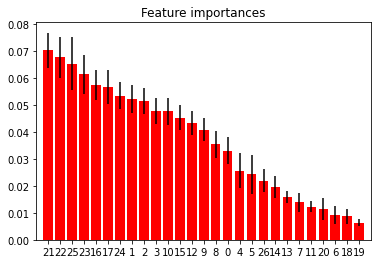

In [57]:
from sklearn.ensemble import ExtraTreesClassifier
scaler = StandardScaler()
X = scaler.fit_transform(pheme_sparse)

forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=3)

forest.fit(X, pheme_y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(pheme_sparse.shape[1]):
    print("%d. feature %d: %s (%f)" % (f + 1, indices[f], pheme_sparse.columns[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(pheme_sparse.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(pheme_sparse.shape[1]), indices)
plt.xlim([-1, pheme_sparse.shape[1]])
plt.show()

In [ ]:
# Sparse

In [25]:
## Data

In [30]:
pheme_sparse.head()
# pheme_sparse.info()

,URLcount,Noun,Verb,Adjective,Pronoun,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,Adverb,Numeral,...,word_count,has_question,has_exclaim,has_period,capital_ratio,tweet_count,listed_count,friends_count,follow_ratio,verified
0,1,7,2,0,0,0,0,0,0,0,...,12,0,0,1,0.159091,15.956172,7177,614,17.564194,1
1,0,3,2,0,0,0,0,0,0,0,...,6,0,0,1,0.037736,10.071462,140,375,12.201205,0
2,0,4,4,7,0,0,0,0,1,0,...,18,0,0,1,0.073529,12.810170,758,592,14.316352,0
3,2,4,5,1,0,0,0,0,0,0,...,16,0,0,1,0.101449,15.732035,102287,1038,23.876904,1
4,2,7,2,0,0,0,0,0,0,0,...,13,0,0,1,0.145299,16.680002,13583,460,19.683865,1


In [ ]:
## CLF

In [31]:
clf = make_pipeline((StandardScaler()), SVC(gamma='auto'))
train_test(pheme_sparse, ext_sparse, pheme_y, ext_y, clf)

Accuracy:		 0.2865979381443299
Precision Score:	 0.9259259259259259
Recall Score:		0.06775067750677506
F1 Score:		 0.2617375849083166
              precision    recall  f1-score   support

           0       0.25      0.98      0.40       116
           1       0.93      0.07      0.13       369

    accuracy                           0.29       485
   macro avg       0.59      0.53      0.26       485
weighted avg       0.76      0.29      0.19       485



In [32]:
clf = GaussianNB()
train_test(pheme_sparse, ext_sparse, pheme_y, ext_y, clf)

Accuracy:		 0.23917525773195877
Precision Score:	 0.5
Recall Score:		0.0027100271002710027
F1 Score:		 0.19468206219710296
              precision    recall  f1-score   support

           0       0.24      0.99      0.38       116
           1       0.50      0.00      0.01       369

    accuracy                           0.24       485
   macro avg       0.37      0.50      0.19       485
weighted avg       0.44      0.24      0.10       485



In [33]:
clf = make_pipeline((StandardScaler()), GradientBoostingClassifier())
train_test(pheme_sparse, ext_sparse, pheme_y, ext_y, clf)

Accuracy:		 0.31958762886597936
Precision Score:	 0.975609756097561
Recall Score:		0.10840108401084012
F1 Score:		 0.302918118466899
              precision    recall  f1-score   support

           0       0.26      0.99      0.41       116
           1       0.98      0.11      0.20       369

    accuracy                           0.32       485
   macro avg       0.62      0.55      0.30       485
weighted avg       0.80      0.32      0.25       485



In [40]:
# clf = make_pipeline((StandardScaler()), model.best_estimator_)
clf = make_pipeline((StandardScaler()), AdaBoostClassifier())
train_test(pheme_sparse, ext_sparse, pheme_y, ext_y, clf)

Accuracy:		 0.32989690721649484
Precision Score:	 0.9074074074074074
Recall Score:		0.13279132791327913
F1 Score:		 0.3187642892026571
              precision    recall  f1-score   support

           0       0.26      0.96      0.41       116
           1       0.91      0.13      0.23       369

    accuracy                           0.33       485
   macro avg       0.58      0.54      0.32       485
weighted avg       0.75      0.33      0.27       485



In [ ]:
## SPARSE - PHEME CV

In [37]:
X = cv[3][1].drop(['target', 'Event'],axis=1)
y = cv[3][1].target
val_X = cv[3][0].drop(['target', 'Event'],axis=1)
val_y = cv[3][0].target
clf = SVC(gamma='auto')
train_test(X, val_X, y, val_y, clf)
# valid(rhi, rhi_y, clf)

Accuracy:		 0.47191011235955055
Precision Score:	 0.0
Recall Score:		0.0
F1 Score:		 0.32061068702290074
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       420
           1       0.00      0.00      0.00       470

    accuracy                           0.47       890
   macro avg       0.24      0.50      0.32       890
weighted avg       0.22      0.47      0.30       890



/Users/june/miniconda3/envs/rosetta/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/june/miniconda3/envs/rosetta/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/june/miniconda3/envs/rosetta/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/june/m

In [ ]:
# Sparse + W2V

In [ ]:
## Data

In [21]:
sparse_w2v = pd.concat([pheme_sparse, pheme_AVGw2v],axis=1)
sparse_w2v_ext = pd.concat([ext_sparse, ext_AVGw2v],axis=1)

In [23]:
sparse_w2v.head(3).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Columns: 227 entries, URLcount to vec_avg199
dtypes: bool(4), float64(203), int64(20)
memory usage: 5.4 KB


In [ ]:
## CLF

In [146]:
clf = make_pipeline((StandardScaler()), SVC(gamma='auto'))
train_test(sparse_w2v, sparse_w2v_ext, pheme_y, ext_y, clf)

Accuracy:		 0.29690721649484536
Precision Score:	 0.8888888888888888
Recall Score:		0.08672086720867209
F1 Score:		 0.27724243417458755
              precision    recall  f1-score   support

           0       0.25      0.97      0.40       116
           1       0.89      0.09      0.16       369

    accuracy                           0.30       485
   macro avg       0.57      0.53      0.28       485
weighted avg       0.74      0.30      0.22       485



In [147]:
clf = make_pipeline((StandardScaler()), GaussianNB())
train_test(sparse_w2v, sparse_w2v_ext, pheme_y, ext_y, clf)

Accuracy:		 0.3525773195876289
Precision Score:	 0.9365079365079365
Recall Score:		0.15989159891598917
F1 Score:		 0.3447525127357841
              precision    recall  f1-score   support

           0       0.27      0.97      0.42       116
           1       0.94      0.16      0.27       369

    accuracy                           0.35       485
   macro avg       0.60      0.56      0.34       485
weighted avg       0.78      0.35      0.31       485



In [152]:
clf = make_pipeline((StandardScaler()), LogisticRegression())
train_test(sparse_w2v, sparse_w2v_ext, pheme_y, ext_y, clf)

Accuracy:		 0.44948453608247424
Precision Score:	 0.8923076923076924
Recall Score:		0.3143631436314363
F1 Score:		 0.4490254394138596
              precision    recall  f1-score   support

           0       0.29      0.88      0.43       116
           1       0.89      0.31      0.46       369

    accuracy                           0.45       485
   macro avg       0.59      0.60      0.45       485
weighted avg       0.75      0.45      0.46       485



/Users/june/miniconda3/envs/rosetta/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [153]:
clf = make_pipeline((StandardScaler()), GradientBoostingClassifier())
train_test(sparse_w2v, sparse_w2v_ext, pheme_y, ext_y, clf)

Accuracy:		 0.311340206185567
Precision Score:	 0.9069767441860465
Recall Score:		0.10569105691056911
F1 Score:		 0.29537704005289345
              precision    recall  f1-score   support

           0       0.25      0.97      0.40       116
           1       0.91      0.11      0.19       369

    accuracy                           0.31       485
   macro avg       0.58      0.54      0.30       485
weighted avg       0.75      0.31      0.24       485



In [162]:
# # ------------------------------------ RF ------------------------------------ #

# model = RandomForestClassifier()
# param_grid = {
#     'n_estimators': [400, 700, 1000],
#     'max_depth': [15,20,25],
#     'max_leaf_nodes': [50, 100, 200]
# }

# model, pred = algorithm_pipeline(pheme_sparse, ext_sparse, pheme_y, ext_y, model, 
#                                  param_grid, cv=5, scoring_fit='accuracy')

# print(model.best_score_)
# print(model.best_params_)

clf = make_pipeline((StandardScaler()), model.best_estimator_)
train_test(sparse_w2v, sparse_w2v_ext, pheme_y, ext_y, clf)

Accuracy:		 0.25773195876288657
Precision Score:	 1.0
Recall Score:		0.024390243902439025
F1 Score:		 0.21975546975546975
              precision    recall  f1-score   support

           0       0.24      1.00      0.39       116
           1       1.00      0.02      0.05       369

    accuracy                           0.26       485
   macro avg       0.62      0.51      0.22       485
weighted avg       0.82      0.26      0.13       485



In [ ]:
# BERT

In [ ]:
## Data

In [17]:
# pheme_y.head()
pheme_bert.head()

,BERTEmbed_0,BERTEmbed_1,BERTEmbed_2,BERTEmbed_3,BERTEmbed_4,BERTEmbed_5,BERTEmbed_6,BERTEmbed_7,BERTEmbed_8,BERTEmbed_9,...,BERTEmbed_758,BERTEmbed_759,BERTEmbed_760,BERTEmbed_761,BERTEmbed_762,BERTEmbed_763,BERTEmbed_764,BERTEmbed_765,BERTEmbed_766,BERTEmbed_767
0,0.299457,0.198897,-0.491295,0.211787,0.197080,0.234026,0.200608,-0.096086,0.250423,0.266876,...,0.209932,-0.166056,0.245046,-0.580443,-0.141690,0.222918,-0.144328,0.048243,-0.027414,-0.055394
1,0.299628,0.207495,-0.491100,0.207046,0.198606,0.223802,0.201070,-0.085390,0.272306,0.276768,...,0.227522,-0.168281,0.246145,-0.575933,-0.133583,0.210461,-0.141031,0.049042,-0.035745,-0.065774
2,0.300907,0.193260,-0.498778,0.215972,0.193097,0.223985,0.181815,-0.106533,0.247362,0.262557,...,0.210722,-0.168287,0.242233,-0.579043,-0.142183,0.223372,-0.142068,0.043969,-0.031963,-0.054336
3,0.294519,0.198307,-0.492020,0.211912,0.201571,0.225530,0.192947,-0.100199,0.261141,0.264648,...,0.216593,-0.163219,0.242032,-0.586569,-0.137623,0.219293,-0.139870,0.039641,-0.034909,-0.062468
4,0.296625,0.196416,-0.493361,0.214012,0.195244,0.231359,0.194209,-0.101270,0.252890,0.263173,...,0.211895,-0.166441,0.237079,-0.587006,-0.140724,0.224566,-0.142844,0.041942,-0.030708,-0.056173


In [6]:
## CLF

In [56]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
train_test(pheme_bert, ext_bert, pheme_y, ext_y, clf)

Accuracy:		 0.3938144329896907
Precision Score:	 0.8205128205128205
Recall Score:		0.2601626016260163
F1 Score:		 0.393811855933068
              precision    recall  f1-score   support

           0       0.26      0.82      0.39       116
           1       0.82      0.26      0.40       369

    accuracy                           0.39       485
   macro avg       0.54      0.54      0.39       485
weighted avg       0.69      0.39      0.39       485



In [53]:
clf = make_pipeline(StandardScaler(), GaussianNB())
# clf = GaussianNB()
train_test(pheme_bert, ext_bert, pheme_y, ext_y, clf)

Accuracy:		 0.6268041237113402
Precision Score:	 0.7596685082872928
Recall Score:		0.7452574525745257
F1 Score:		 0.49753590255796776
              precision    recall  f1-score   support

           0       0.24      0.25      0.24       116
           1       0.76      0.75      0.75       369

    accuracy                           0.63       485
   macro avg       0.50      0.50      0.50       485
weighted avg       0.63      0.63      0.63       485



In [58]:
clf = make_pipeline(StandardScaler(), GradientBoostingClassifier())
train_test(pheme_bert, ext_bert, pheme_y, ext_y, clf)

Accuracy:		 0.30721649484536084
Precision Score:	 0.9230769230769231
Recall Score:		0.0975609756097561
F1 Score:		 0.2893029097760101
              precision    recall  f1-score   support

           0       0.25      0.97      0.40       116
           1       0.92      0.10      0.18       369

    accuracy                           0.31       485
   macro avg       0.59      0.54      0.29       485
weighted avg       0.76      0.31      0.23       485



In [62]:
# clf = make_pipeline((StandardScaler()), model.best_estimator_)
# clf = make_pipeline(StandardScaler(), AdaBoostClassifier())
clf = AdaBoostClassifier()
train_test(pheme_bert, ext_bert, pheme_y, ext_y, clf)

Accuracy:		 0.3835051546391753
Precision Score:	 0.9375
Recall Score:		0.2032520325203252
F1 Score:		 0.3800896853318742
              precision    recall  f1-score   support

           0       0.27      0.96      0.43       116
           1       0.94      0.20      0.33       369

    accuracy                           0.38       485
   macro avg       0.61      0.58      0.38       485
weighted avg       0.78      0.38      0.36       485



In [ ]:
# BERT + SPARSE